In [1]:
import findspark
findspark.init()

In [2]:
import sys
sys.path.append("../")

In [3]:
from src.utils import create_spark_session, load_data, count_distinct_values, count_missing_values
from pyspark.sql.functions import col, when

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
spark = create_spark_session()

In [6]:
books = load_data(spark, "../data/raw/Books.csv")
rates = load_data(spark, "../data/raw/Ratings.csv")
users = load_data(spark, "../data/raw/Users.csv")

## Exploration Books.csv

In [7]:
books.toPandas()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...
...,...,...,...,...,...,...,...,...
271355,0440400988,There's a Bat in Bunk Five,Paula Danziger,1988,Random House Childrens Pub (Mm),http://images.amazon.com/images/P/0440400988.0...,http://images.amazon.com/images/P/0440400988.0...,http://images.amazon.com/images/P/0440400988.0...
271356,0525447644,From One to One Hundred,Teri Sloat,1991,Dutton Books,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...
271357,006008667X,Lily Dale : The True Story of the Town that Ta...,Christine Wicker,2004,HarperSanFrancisco,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...
271358,0192126040,Republic (World's Classics),Plato,1996,Oxford University Press,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...


In [8]:
books.printSchema()

root
 |-- ISBN: string (nullable = true)
 |-- Book-Title: string (nullable = true)
 |-- Book-Author: string (nullable = true)
 |-- Year-Of-Publication: string (nullable = true)
 |-- Publisher: string (nullable = true)
 |-- Image-URL-S: string (nullable = true)
 |-- Image-URL-M: string (nullable = true)
 |-- Image-URL-L: string (nullable = true)



In [9]:
count_distinct_values(books).show()

+------+----------+-----------+-------------------+---------+-----------+-----------+-----------+
|  ISBN|Book-Title|Book-Author|Year-Of-Publication|Publisher|Image-URL-S|Image-URL-M|Image-URL-L|
+------+----------+-----------+-------------------+---------+-----------+-----------+-----------+
|271360|    242134|     102052|                169|    16843|     271038|     271044|     271041|
+------+----------+-----------+-------------------+---------+-----------+-----------+-----------+



In [10]:
count_missing_values(books).show()

+----+----------+-----------+-------------------+---------+-----------+-----------+-----------+
|ISBN|Book-Title|Book-Author|Year-Of-Publication|Publisher|Image-URL-S|Image-URL-M|Image-URL-L|
+----+----------+-----------+-------------------+---------+-----------+-----------+-----------+
|   0|         0|          1|                  0|        2|          0|          0|          3|
+----+----------+-----------+-------------------+---------+-----------+-----------+-----------+



In [11]:
print(f"Nombres de lignes dupliqués : {books.toPandas().duplicated().sum()}")  

Nombres de lignes dupliqués : 0


In [12]:
annee_min_valide = 1900
annee_max_valide = 2022

# Filtrer les années valides et non valides
annees_valides = books.filter((col("Year-Of-Publication").isNotNull()) & (col("Year-Of-Publication").between(annee_min_valide, annee_max_valide)))
annees_non_valides = books.filter(~((col("Year-Of-Publication").isNotNull()) & (col("Year-Of-Publication").between(annee_min_valide, annee_max_valide))))

# Collecter les résultats
liste_annees_valides = annees_valides.select("Year-Of-Publication").distinct().collect()
liste_annees_non_valides = annees_non_valides.select("Year-Of-Publication").distinct().collect()

# Afficher les résultats
print("Liste des années valides (", annees_valides.count(),"):", [row["Year-Of-Publication"] for row in liste_annees_valides])
print("Liste des années non valides (", annees_non_valides.count(),") :", [row["Year-Of-Publication"] for row in liste_annees_non_valides])

Liste des années valides ( 266668 ): ['1953', '1957', '1987', '1956', '1936', '2020', '1958', '1943', '1972', '1988', '1926', '1977', '1971', '1984', '1982', '1941', '2005', '2000', '1965', '1962', '1954', '1930', '1981', '1940', '1978', '1974', '2002', '1959', '1995', '1964', '1946', '1976', '1942', '1947', '1968', '1967', '2004', '1989', '2011', '1939', '1992', '1961', '1966', '1951', '1955', '1999', '1963', '1994', '1950', '1997', '1973', '1925', '1996', '1983', '1969', '1923', '1980', '1960', '1937', '1948', '1986', '1952', '1985', '1979', '1998', '1993', '2001', '1990', '1991', '2003', '1945', '1975', '1970', '1920', '1931', '1938', '1911', '1932', '1904', '1927', '1929', '1949', '1928', '1910', '1921', '1924', '1914', '1902', '1934', '1933', '1901', '1900', '1917', '1944', '1906', '1908', '1935', ' 1961', '2010', '2012', '2006', '2021', '1919', '1909', '1922', '2008']
Liste des années non valides ( 4635 ) : ['0', '2030', '2050', '2026', '2038', '1806', '1897', '1378', '2024', '20

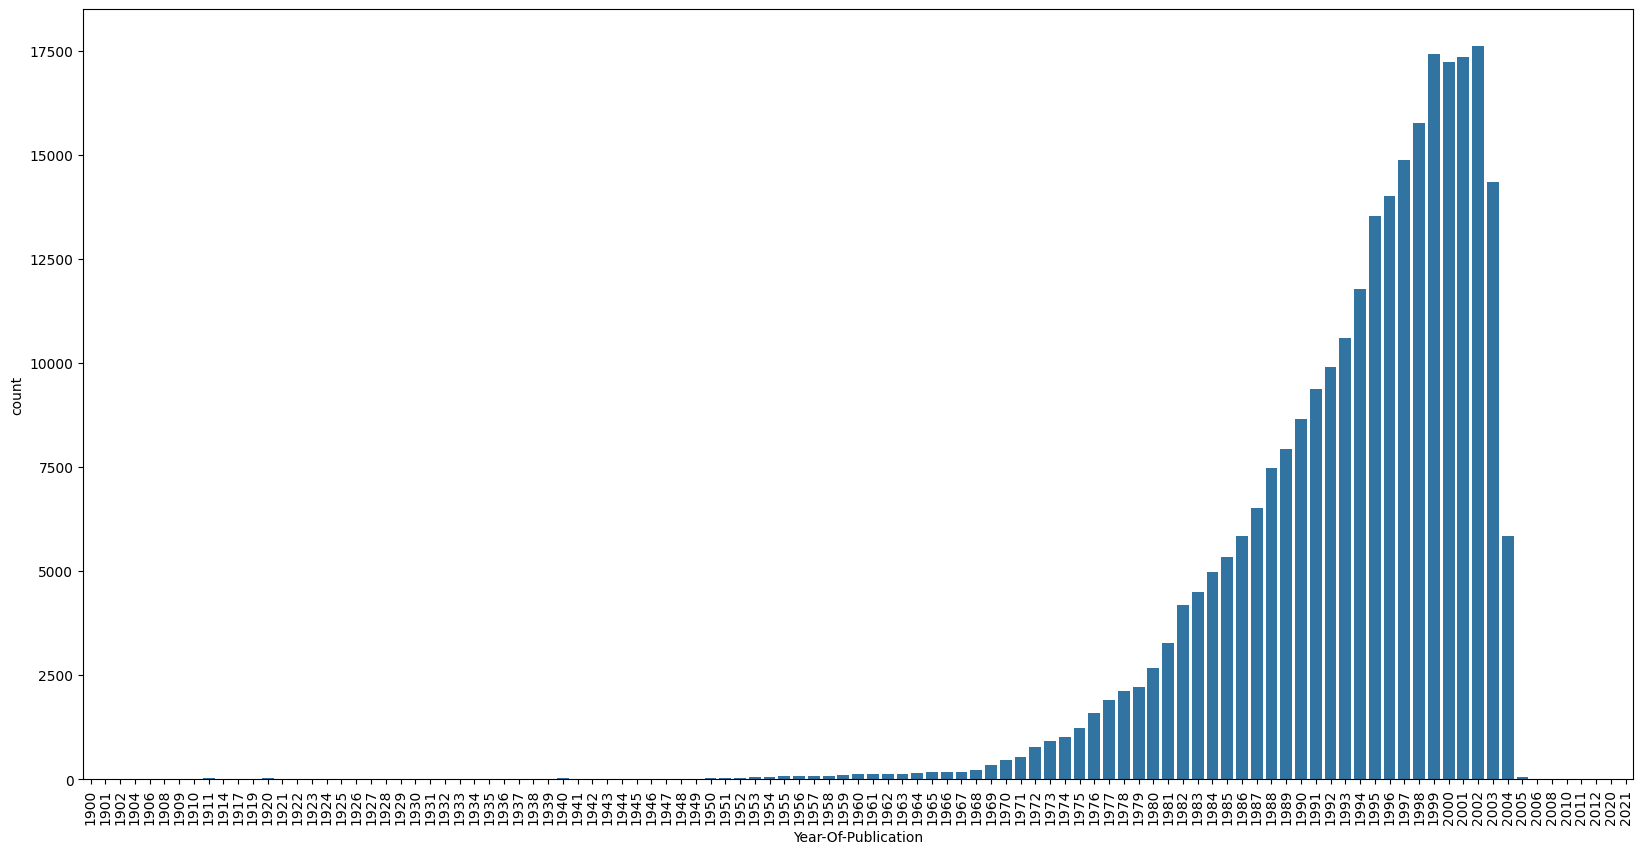

In [13]:
annees_valides = annees_valides.withColumn("Year-Of-Publication", annees_valides["Year-Of-Publication"].cast("integer"))

plt.figure(figsize=(20,10))
sns.countplot(x=annees_valides.toPandas()['Year-Of-Publication'])
plt.xticks(rotation=90)
plt.show()

La majorité des livres a été publié entre 1980 et 2004

## Exploration Rates.csv

In [14]:
rates.toPandas()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6
...,...,...,...
1149775,276704,1563526298,9
1149776,276706,0679447156,0
1149777,276709,0515107662,10
1149778,276721,0590442449,10


In [15]:
rates.printSchema()

root
 |-- User-ID: integer (nullable = true)
 |-- ISBN: string (nullable = true)
 |-- Book-Rating: integer (nullable = true)



In [16]:
count_distinct_values(rates).show()

+-------+------+-----------+
|User-ID|  ISBN|Book-Rating|
+-------+------+-----------+
| 105283|340556|         11|
+-------+------+-----------+



In [17]:
count_missing_values(rates).show()

+-------+----+-----------+
|User-ID|ISBN|Book-Rating|
+-------+----+-----------+
|      0|   0|          0|
+-------+----+-----------+



In [18]:
rates_count = rates.groupby("Book-Rating").count()

<Axes: xlabel='Book-Rating'>

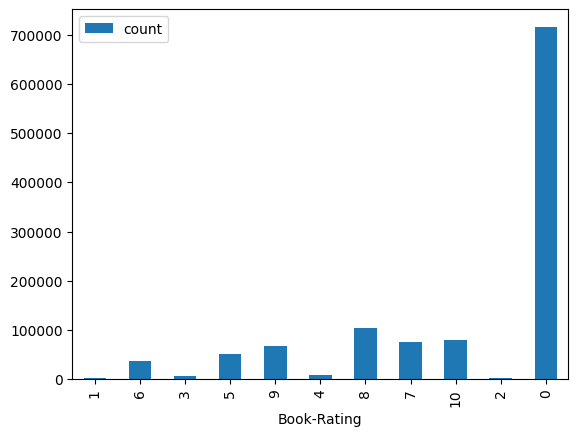

In [19]:
rates_count.toPandas().plot(kind="bar", x='Book-Rating', y='count')

Il est courant dans les systèmes de recommandation de disposer de données de rétroaction implicite, où les utilisateurs ne fournissent pas explicitement de notes, mais où leurs actions peuvent être utilisées comme une indication de préférence. Dans ce cas, une note de 0 pourrait représenter une note manquante ou inconnue, qui est souvent traitée comme un "retour négatif implicite". Cela signifie que les utilisateurs qui n'ont pas fourni de note pour un livre n'indiquent pas nécessairement qu'ils n'aiment pas le livre ; ils n'ont peut-être tout simplement pas exprimé d'opinion à ce sujet.

In [20]:
print(f"Nombres de lignes dupliqués : {rates.toPandas().duplicated().sum()}")  

Nombres de lignes dupliqués : 0


## Exploration Users.csv

In [21]:
users.toPandas()

,User-ID,Location,Age
0,1.0,"nyc, new york, usa",None
1,2.0,"stockton, california, usa",18.0
2,3.0,"moscow, yukon territory, russia",None
3,4.0,"porto, v.n.gaia, portugal",17.0
4,5.0,"farnborough, hants, united kingdom",None
...,...,...,...
278854,278854.0,"portland, oregon, usa",None
278855,278855.0,"tacoma, washington, united kingdom",50.0
278856,278856.0,"brampton, ontario, canada",None
278857,278857.0,"knoxville, tennessee, usa",None


In [22]:
count_distinct_values(users).show()

+-------+--------+---+
|User-ID|Location|Age|
+-------+--------+---+
| 278858|   57329|250|
+-------+--------+---+



In [23]:
count_missing_values(users).show()

+-------+--------+------+
|User-ID|Location|   Age|
+-------+--------+------+
|      1|       0|110518|
+-------+--------+------+



In [24]:
print(f"Nombres de lignes dupliqués : {books.toPandas().duplicated().sum()}")  

Nombres de lignes dupliqués : 0


In [25]:
"""
from src.preprocessing import preprocess_ratings
pre_rate = preprocess_ratings(rates, nb=500)
pre_rate.toPandas()
rating_counts_per_user = pre_rate.groupBy('User-ID').agg(F.count('Book-Rating').alias('num_ratings_per_user'))
rating_counts_per_user.show()

pdr = pre_rate.toPandas()
x = pdr["User-ID"].value_counts()>200
y = x[x].index
y.shape
"""
print()

In [26]:
from src.preprocessing import preprocess

In [27]:
preprocessed = preprocess(books, rates, users, nbRatings = 200, file_path="output.csv")

In [28]:
preprocessed.toPandas()

,Book-Title,ISBN,User-ID,Book-Rating,Book-Author,Year-Of-Publication,Publisher
0,Midnight,0425118703,278418,1,Dean R. Koontz,1995,Berkley Publishing Group
1,Midnight,0425118703,7346,1,Dean R. Koontz,1995,Berkley Publishing Group
2,Midnight,0425118703,11676,8,Dean R. Koontz,1995,Berkley Publishing Group
3,Midnight,0425118703,12538,9,Dean R. Koontz,1995,Berkley Publishing Group
4,Midnight,0425118703,31315,1,Dean R. Koontz,1995,Berkley Publishing Group
...,...,...,...,...,...,...,...
61771,Fast Food Nation: The Dark Side of the All-Ame...,0060938455,266865,10,Eric Schlosser,2002,Perennial
61772,Fast Food Nation: The Dark Side of the All-Ame...,0060938455,270713,2,Eric Schlosser,2002,Perennial
61773,Fast Food Nation: The Dark Side of the All-Ame...,0060938455,271448,2,Eric Schlosser,2002,Perennial
61774,Fast Food Nation: The Dark Side of the All-Ame...,0060938455,271705,2,Eric Schlosser,2002,Perennial


In [29]:
from src.preprocessing import pivot

In [30]:
pivot_df = pivot(preprocessed)

In [31]:
# Afficher le DataFrame pivoté
pivot_df.toPandas()

,Book-Title,254,2276,2766,2977,3363,3757,4017,4385,6242,...,274004,274061,274301,274308,274808,275970,277427,277478,277639,278418
0,Midnight,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,The Bridges of Madison County,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,6,0,0,0,1
2,"Loves Music, Loves to Dance",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,Mercy,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,2,0
4,The Pull of the Moon,0,0,0,0,0,0,3,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
736,Jewel,0,0,0,0,0,0,10,0,0,...,0,0,0,0,0,0,0,0,0,0
737,Guilty as Sin,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
738,Confessions of an Ugly Stepsister : A Novel,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
739,Macgregor Brides (Macgregors),0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
spark.stop()